In [1]:
import os, sys
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.dataprocessing.transformers.diff import Diff
from darts.utils.statistics import plot_hist
from darts.models import LightGBMModel, XGBModel, LinearRegressionModel, TFTModel, NHiTSModel, RNNModel, TFTModel
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch

from utils import *
import wandb
wandb.login()


import warnings
warnings.filterwarnings('ignore')

# Set seed
np.random.seed(42)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


In [2]:
# Set working directory
os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
# run parameters

config_dataset = {
    'spatial_scale': '1_county',
    'temp_resolution': 60,
    'location': 'New_York',
}

config_modeldesign = {'boxcox': True,
                    'horizon_in_hours': 24, # in hours
                    'lookback_in_hours': 24, # in hours
                    'liklihood': None,
                    'weather': True,
                    'holiday': True,
                    'datetime_encodings': True,
                    }
                   
config_encoders =  {
                    "cyclic": {"future": ["hour"]}, 
                    "position": {"future": ["relative",]},
                    "datetime_attribute": {"future": ["dayofweek", "week"]},
                    'position': {'past': ['relative'], 'future': ['relative']},
            }



In [4]:
# initialize wandb and log config
wandb.init(project="WattCast", config=config_dataset, name=config_dataset['spatial_scale']+ "_" + config_dataset['location'] + "_" + str(config_dataset['temp_resolution']) + "min")
config = wandb.config
config.update(config_modeldesign)
config.update(config_encoders)

In [6]:
# calculate derived parameters
datetime_encoders = config_encoders if config.datetime_encodings else None
timesteps_per_hour = int(60 / config.temp_resolution)
n_lags = config.lookback_in_hours * timesteps_per_hour
n_ahead = config.horizon_in_hours * timesteps_per_hour
list_metrics = [smape, mape, rmse, r2_score, mae] # evaluation metrics
eval_stride = n_ahead // 5 # use something that samples from multiple starting points over the entire (to remove out the autocorrelation of errors for the evaluation)

# Loading Data
df_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_target')
df_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_target')
df_test = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_target')
df_cov_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_cov')
df_cov_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_cov')
df_cov_test = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_cov')

In [7]:
# into darts format
ts_train = darts.TimeSeries.from_dataframe(df_train)
ts_val = darts.TimeSeries.from_dataframe(df_val)
ts_test = darts.TimeSeries.from_dataframe(df_test)

# Covariates
ts_cov_train = darts.TimeSeries.from_dataframe(df_cov_train)
ts_cov_val = darts.TimeSeries.from_dataframe(df_cov_val)[:1000]
ts_cov_test = darts.TimeSeries.from_dataframe(df_cov_test)[:1000]

# make sure the indices are the same, TODO: move this to the data_prep.ipynb
ts_train, ts_cov_train = make_index_same(ts_train, ts_cov_train)
ts_val, ts_cov_val = make_index_same(ts_val, ts_cov_val)
ts_test, ts_cov_test = make_index_same(ts_test, ts_cov_test)

In [8]:
# Load pipeline
pipeline = Pipeline(
                    [
                    BoxCox() if config.boxcox else None,
                    Scaler(MinMaxScaler()),
                    ]
                     )

ts_train_piped = pipeline.fit_transform(ts_train)
ts_val_piped = pipeline.transform(ts_val)
ts_test_piped = pipeline.transform(ts_test)

# Weather Pipeline
pipeline_weather = Pipeline([Scaler(RobustScaler())])
ts_train_weather_piped = pipeline_weather.fit_transform(ts_cov_train)
ts_val_weather_piped = pipeline_weather.transform(ts_cov_val)
ts_test_weather_piped = pipeline_weather.transform(ts_cov_test)

In [9]:
trg_train_inversed = pipeline.inverse_transform(ts_train_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_val_inversed = pipeline.inverse_transform(ts_val_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_test_inversed = pipeline.inverse_transform(ts_test_piped, partial=True) # inverse transform the target, we need the original values for the evaluation

In [30]:
# Models

# sklearn models
lr_model = LinearRegressionModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders, 
                output_chunk_length=n_ahead, 
                likelihood=config.liklihood)

        
xgb_model = XGBModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders, 
                output_chunk_length=n_ahead, 
                likelihood=config.liklihood)


lgbm_model = LightGBMModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders,
                output_chunk_length=n_ahead,
                likelihood=config.liklihood)
            




# torch models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pl_trainer_kwargs = {
    'max_epochs': 100,
    'accelerator': 'gpu',
    'devices': [0],
    'callbacks': [EarlyStopping(monitor='train_loss', patience=3, mode='min')],
}


# TODO Instead of training here we will load the pretrained models from the hyperparameter_tuning.ipynb

rnn_model = RNNModel(  
                        model = 'GRU',
                        input_chunk_length=n_lags,
                        output_chunk_length=n_ahead,
                        hidden_dim=128,
                        add_encoders=datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        random_state=42,
                        )

transformer_model = TFTModel(
                        input_chunk_length=n_lags,
                        output_chunk_length=n_ahead,
                        add_encoders=datetime_encoders,
                        hidden_size=1024,
                        num_attention_heads=8,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        random_state=42,
                        )



model_instances = [
                    #lr_model, 
                    #xgb_model,
                    #lgbm_model, 
                    #rnn_model, 
                    transformer_model
                    ]


In [31]:

models = train_models(model_instances, 
                        ts_train_piped,
                        ts_train_weather_piped if config.weather else None,
                        )

model_names = [model.__class__.__name__ for model in models]
models_dict = {model_name: model for model_name, model in zip(model_names, models)}

Training TFTModel


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 198 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 148 K 
6  | static_context_grn                | _GatedResidualNetwork            | 4.2 M 
7  | static_context_hidden_encoder_grn | _GatedResid

Training: 0it [00:00, ?it/s]

In [32]:
test_sets = {"Winter": (ts_val_piped, ts_cov_val, trg_val_inversed), "Summer": (ts_test_piped, ts_cov_test,trg_test_inversed)} # see data_prep.ipynb for the split

In [ ]:

dict_result_season = {}
for season, (ts, ts_cov, gt) in test_sets.items():
    print(f"Testing on {season} data")
    # Generating Historical Forecasts for each model
    ts_predictions_per_model = {}
    historics_per_model = {}
    for model_name, model in models_dict.items():
        print(f"Generating historical forecasts for {model_name}")
        covs_use = None if not config.weather else ts_cov
        historics = model.historical_forecasts(ts, 
                                            future_covariates= covs_use,
                                            start=ts_test_piped.get_index_at_point(n_lags),
                                            verbose=True,
                                            stride=3, 
                                            forecast_horizon=n_ahead, 
                                            retrain=False, 
                                            last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
                                            )
        
        historics_per_model[model_name] = historics # storing the forecasts in batches of the forecasting horizon, for plot 2
        ts_predictions = ts_list_concat(historics, eval_stride) # concatenating the batches into a single time series for plot 1, this keeps the n_ahead
        ts_predictions_inverse = pipeline.inverse_transform(ts_predictions) # inverse transform the predictions, we need the original values for the evaluation
        ts_predictions_per_model[model_name] = ts_predictions_inverse
    
    
    dict_result_season[season] = historics_per_model, ts_predictions_per_model, gt

## Plots & Analysis

### Plot 1: Side-by-side comparison of the models

In [34]:
for season, (_, preds_per_model, gt) in dict_result_season.items():
    fig = px.line(gt.pd_series().to_frame("ground_truth"))
    for model_name in model_names:
        preds = preds_per_model[model_name]
        fig.add_scatter(x=preds.pd_series().index, y=preds.pd_series().values, name="prediction_" + model_name)
    
    fig.update_layout(title=f"{season}")
    fig.update_xaxes(title_text="Time")
    fig.update_yaxes(title_text=f"Power [{ts_train.components[0][-2:]}]")
    fig.show()
    wandb.log({f"{season} - Side-by-side comparison of predictions and the ground truth for {config.spatial_scale} in {config.location}": fig})

### Error Metrics Table

In [43]:
dict_table_metrics_per_season = {}

for season, (_, preds_per_model, gt) in dict_result_season.items():
    table = get_error_metric_table(list_metrics, preds_per_model, gt).reset_index()
    wandb.log({f"{season} - Error metrics for {config.spatial_scale} in {config.location}": wandb.Table(dataframe=table)})
    dict_table_metrics_per_season[season] = table


In [47]:
dict_table_metrics_per_season["Winter"]

,index,smape,mape,rmse,r2_score,mae
0,LinearRegressionModel,7.286829,7.295705,1.725638,0.447120,1.337546
1,LightGBMModel,4.280896,4.194684,0.956056,0.818859,0.774559
2,RNNModel,55.021962,41.562276,16.433300,-3.674851,14.512122


### Plot 2: Error Metric Trajectories

Text(0.5, 1.0, 'Normalised RMSE of the Historical Forecasts in New_York')

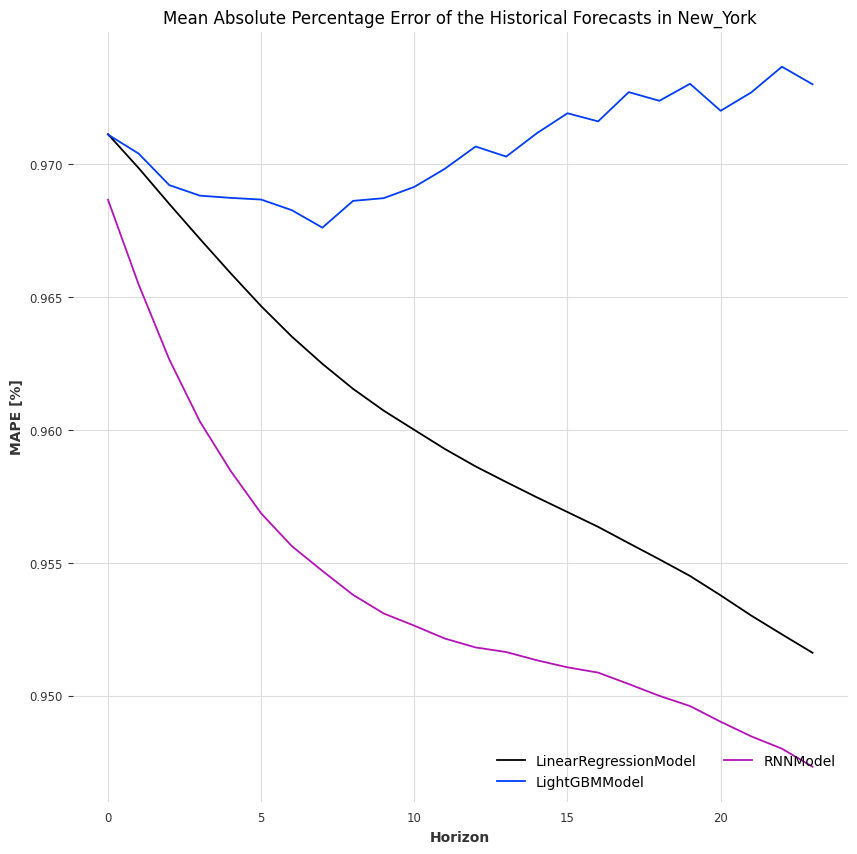

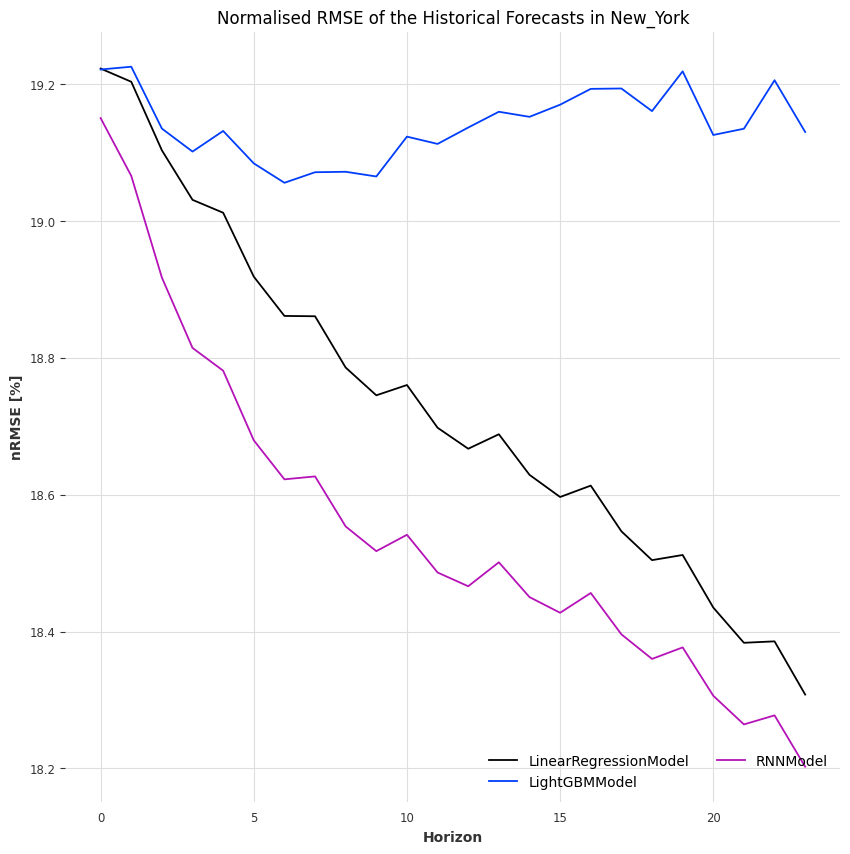

In [48]:
df_smapes_per_model = []
df_nrmse_per_model = []
for model_name, historics in historics_per_model.items():
    df_list = get_df_compares_list(historics, trg_test_inversed)
    means_per_timestep = pd.concat(df_list, axis=1).filter(like = "gt").mean(axis=1).values # mean of the ground truth values on a timestep basis
    diffs = get_df_diffs(df_list)
    df_smapes = abs(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
    df_smapes.columns = [model_name]
    df_nrmse = np.square(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
    df_nrmse.columns = [model_name]

    df_smapes_per_model.append(df_smapes)
    df_nrmse_per_model.append(df_nrmse)

df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1)
df_smapes_per_model.columns = model_names
df_nrmse_per_model = pd.concat(df_nrmse_per_model, axis=1)
df_nrmse_per_model.columns = model_names

df_smapes_per_model.plot(figsize=(10,10))
plt.xlabel('Horizon')
plt.ylabel('MAPE [%]')
plt.legend(loc = 'lower right', ncol = 2)
plt.title(f"Mean Absolute Percentage Error of the Historical Forecasts in {config.location}")

df_nrmse_per_model.plot(figsize=(10,10))
plt.xlabel('Horizon')
plt.ylabel('nRMSE [%]')
plt.legend(loc = 'lower right', ncol = 2)
plt.title(f"Normalised RMSE of the Historical Forecasts in {config.location}")

### Plot 3: Error distribution

In [ ]:
residuals = 

### Plot 4: Performance on Extreme Events